In [ ]:
# hello

In [ ]:
# https://machinelearningmastery.com/building-transformer-models-with-attention-crash-course-build-a-neural-machine-translator-in-12-days/

In [ ]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np

In [ ]:
df = pd.read_csv('/content/gdrive/MyDrive/Tom_Tutoring/Brownlee Transformer 2/all_combined.csv')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26138 entries, 0 to 26137
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  26138 non-null  int64 
 1   email       26137 non-null  object
 2   label       26138 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 612.7+ KB


In [ ]:
df.head()

,Unnamed: 0,email,label
0,0,\nSave up to 70% on Life Insurance.\nWhy Spend...,1
1,1,1) Fight The Risk of Cancer!\nhttp://www.adcli...,1
2,2,1) Fight The Risk of Cancer!\nhttp://www.adcli...,1
3,3,##############################################...,1
4,4,I thought you might like these:\n1) Slim Down ...,1


In [ ]:
df = df[['email','label']]

In [ ]:
df.isna().sum()

email    1
label    0
dtype: int64

In [ ]:
df = df.dropna()
df.shape

(26137, 2)

In [ ]:
df.shape

(26137, 2)

In [ ]:
df['email_length'] = df['email'].apply(len)

In [ ]:
df['email_length'].describe()

count    2.613700e+04
mean     2.435799e+03
std      1.057497e+05
min      1.000000e+00
25%      4.560000e+02
50%      9.220000e+02
75%      1.864000e+03
max      1.708563e+07
Name: email_length, dtype: float64

In [ ]:
df = df.loc[df['email_length'] < 10000]
df.shape

(25670, 3)

In [ ]:
df['label'].describe()

count    25670.000000
mean         0.319011
std          0.466102
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          1.000000
Name: label, dtype: float64

In [ ]:
print(df['label'].unique())

[1 0]


In [ ]:
df = df[['email','label']]
df['label'] = df['label'].astype('float64')

In [ ]:
df_practice = df[['email']]
df_practice = df_practice.dropna()
df_practice.shape

(25670, 1)

In [ ]:
df_practice = df_practice.replace('', np.nan)

In [ ]:
df_practice = df_practice.dropna()
df_practice.shape

(25670, 1)

In [ ]:
# Normalize the text:

In [ ]:
# convert the string into NFKC (compatibility and composition
# normal form)

In [ ]:
import pathlib
import pickle
import random
import re
import unicodedata

import tensorflow as tf



def normalize(line):
  line = str(line)
  line = unicodedata.normalize("NFKC", line.strip().lower())
  line = re.sub(r"^([^ \w])(?!\s)", r"\1 ", line)
  line = re.sub(r"(\s[^ \w])(?!\s)", r"\1 ", line)
  line = re.sub(r"(?!\s)([^ \w])$", r" \1", line)
  line = re.sub(r"(?!\s)([^ \w]\s)", r" \1", line)
  return line

email_list = df['email']

text = [normalize(line) for line in email_list]

for _ in range(5):
  print(random.choice(text))

with open("text.pickle", "wb") as fp:
  pickle.dump(text, fp)

subject : best debt elimination software available  ! free demo  ! great gift  !
 
 best debt elimination software available  ! free demo  ! great gift  ! you do n't need to earn a penny more than you do now  ! you do n't need to  = wait 20  , 30  , even 40 years to get out of debt  ! nor retire in hock to your creditors and survive on the edge with social security alone  ! you can get out of debt in five to seven years on average  ! and you do n't need to be a financial wizard to do it  .  ( please see the end of this message for remove suggestions  .  ) your financial independence day debtfree for windows  ( tm  ) will show you how to get out of debt and will help you pin down your debt  - freedom date  , your financial independence day  ! this easy-to  - use program will calculate and display your step-by  - step accelerated debt-elimination plan  . then it will help you develop and monitor your accelerated wealth-accumulation plan  . this top-of  - the-line software can even show y

In [ ]:
len(text)

25670

In [ ]:
import pickle

with open("text.pickle", "rb") as fp:
  text = pickle.load(fp)

eng_tokens = set()
eng_maxlen = 0
for eng in text:
  eng_tok = eng.split()
  eng_maxlen = max(eng_maxlen, len(eng_tok))

  eng_tokens.update(eng_tok)

print(f"Total English tokens: {len(eng_tokens)}")

print(f"Max English length: {eng_maxlen}")

print(f"{len(text)} total pairs")


Total English tokens: 180327
Max English length: 4705
25670 total pairs


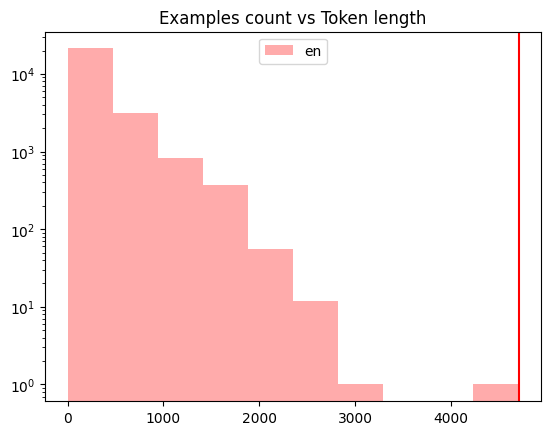

In [ ]:
import pickle

import matplotlib.pyplot as plt

with open("text.pickle", "rb") as fp:
  text = pickle.load(fp)

en_lengths = [len(eng.split()) for eng in text]


plt.hist(en_lengths, label="en", color="red", alpha = 0.33)



plt.yscale("log")
plt.ylim(plt.ylim())

plt.plot([max(en_lengths), max(en_lengths)], plt.ylim(), color="red")


plt.legend()
plt.title("Examples count vs Token length")
plt.show()

In [ ]:
# Next: vectorize this normalized text data

In [ ]:
import pickle

import random

from tensorflow.keras.layers import TextVectorization

with open("text.pickle", "rb") as fp:
  text = pickle.load(fp)

labels = df['label'] # [0, 1, 0]  # Example binary labels (0 for not spam, 1 for spam)

# Combine emails and labels into pairs
email_label_pairs = list(zip(text, labels))


random.shuffle(email_label_pairs)
n_val = int(0.15 * len(email_label_pairs))
n_train = len(email_label_pairs) - 2 * n_val

train_pairs = email_label_pairs[:n_train]
val_pairs = email_label_pairs[n_train:n_train + n_val]
test_pairs = email_label_pairs[n_train + n_val:]

# parameter determined after analyzing the input data
vocab_size_en = 10000


seq_length = 100

eng_vectorizer = TextVectorization(
    max_tokens = vocab_size_en,
    standardize = None,
    split = "whitespace",
    output_mode = "int",
    output_sequence_length = seq_length,
)



train_eng_texts = [pair[0] for pair in train_pairs]


eng_vectorizer.adapt(train_eng_texts)


# save for subsequent steps
with open("vectorize.pickle", "wb") as fp:
  data = {
      "train": train_pairs,
      "val": val_pairs,
      "test": test_pairs,
      "engvec_config": eng_vectorizer.get_config(),
      "engvec_weights": eng_vectorizer.get_weights(),
  }

  pickle.dump(data, fp)


In [ ]:
import pickle

import tensorflow as tf

from tensorflow.keras.layers import TextVectorization

with open("vectorize.pickle", "rb") as fp:
  data = pickle.load(fp)

train_pairs = data["train"]
val_pairs = data["val"]
test_pairs = data["test"]

eng_vectorizer = TextVectorization.from_config(data['engvec_config'])

eng_vectorizer.set_weights(data['engvec_weights'])



# set up dataset object

def format_dataset(eng, label):
  eng = eng_vectorizer(eng)



  source = {'encoder_inputs': eng}



  return source, label

def make_dataset(pairs, batch_size=16):
  eng_texts = [pair[0] for pair in pairs]
  labels = [pair[1] for pair in pairs]

  dataset = tf.data.Dataset.from_tensor_slices((list(eng_texts), list(labels)))
  return dataset.shuffle(2048) \
                .batch(batch_size).map(format_dataset) \
                .prefetch(16).cache()

train_ds = make_dataset(train_pairs)
val_ds = make_dataset(val_pairs)

# test the dataset
for inputs, labels in train_ds.take(1):
  print(f'inputs["encoder_inputs"].shape: {inputs["encoder_inputs"].shape}')
  print(f'inputs["encoder_inputs"][0]: {inputs["encoder_inputs"][0]}')

inputs["encoder_inputs"].shape: (16, 100)
inputs["encoder_inputs"][0]: [  33    7  156   15  334    3    3    3    1  156   15  334 1356    9
  401  278   74    9    5  285  278 5738 3125    6 4343 2797 4013  143
    4    5 1356    9  401  278   17  111  273 1124   49 6735    1  772
    4   11 1340  390 1680    9    1  971    8 5738   13    5  990 2597
    2    5 3487    4 1551   11    2    1    4 3106    2    4    8 2204
  552    2 8030    4  780    6 1538 1189   20    5 1824    8 1143 5286
    9    5  401  155    2    5 1356    9  401  278 3178 8007 9087    8
 6333  825]


In [ ]:
# Positional Encoding Matrix

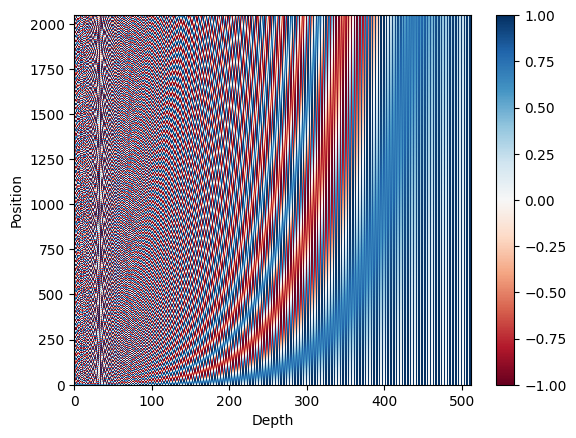

In [ ]:
import pickle

import matplotlib.pyplot as plt
import numpy as np

def pos_enc_matrix(L, d, n=10000):
  assert d % 2 == 0
  d2 = d//2
  P = np.zeros((L, d))
  k = np.arange(L).reshape(-1,1)
  i = np.arange(d2).reshape(1, -1)
  denom = np.power(n, -i/d2)
  args = k * denom
  P[:, ::2] = np.sin(args)
  P[:, 1::2] = np.cos(args)
  return P

# plot the positional encoding matrix
pos_matrix = pos_enc_matrix(L=2048, d=512)
assert pos_matrix.shape == (2048, 512)
plt.pcolormesh(pos_matrix, cmap='RdBu')
plt.xlabel('Depth')
plt.ylabel('Position')
plt.colorbar()
plt.show()

with open("posenc-2048-512.pickle", "wb") as fp:
  pickle.dump(pos_matrix, fp)



In [ ]:
# separate the sine curves from the cosine curves

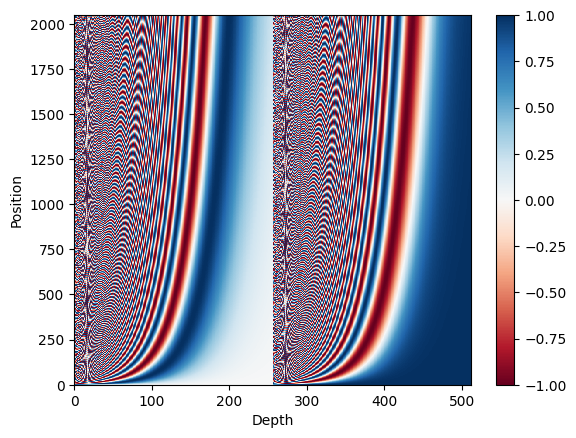

In [ ]:
import pickle

import matplotlib.pyplot as plt
import numpy as np

with open("posenc-2048-512.pickle", "rb") as fp:
  pos_matrix = pickle.load(fp)

assert pos_matrix.shape == (2048, 512)

# plot the positional encoding matrix, alternative way

plt.pcolormesh(np.hstack([pos_matrix[:, ::2], pos_matrix[:, 1::2]]), cmap='RdBu')
plt.xlabel('Depth')
plt.ylabel('Position')
plt.colorbar()
plt.show()

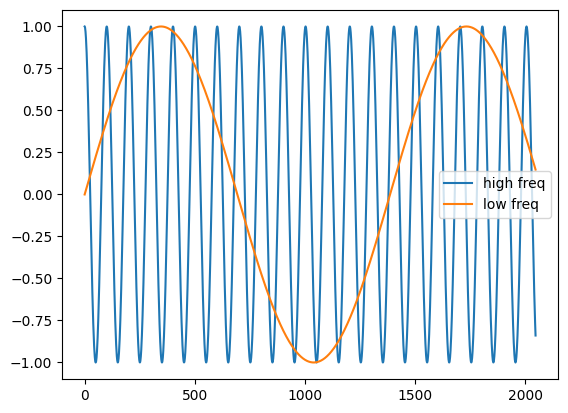

In [ ]:
plt.plot(pos_matrix[:, 155], label='high freq')
plt.plot(pos_matrix[:, 300], label='low freq')

plt.legend()
plt.show()

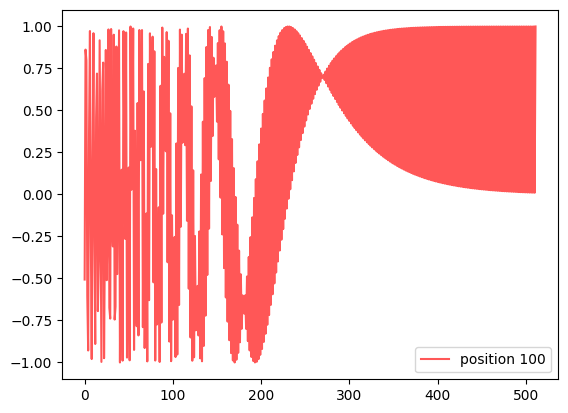

In [ ]:
with open("posenc-2048-512.pickle", "rb") as fp:
  pos_matrix = pickle.load(fp)

assert pos_matrix.shape == (2048, 512)

plt.plot(pos_matrix[100], alpha=0.66, color="red", label="position 100")

plt.legend()
plt.show()

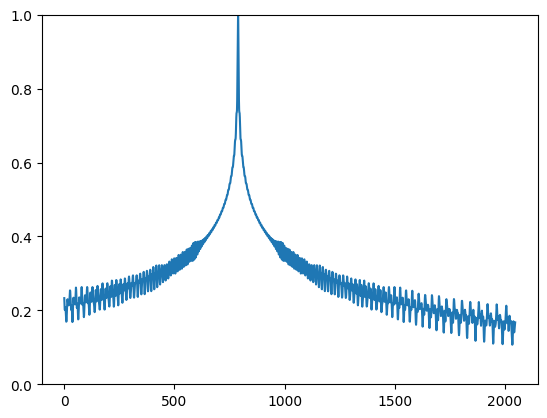

In [ ]:
with open("posenc-2048-512.pickle", "rb") as fp:
  pos_matrix = pickle.load(fp)

assert pos_matrix.shape == (2048, 512)

# show the dot product between different normalized positional vectors
pos_matrix /= np.linalg.norm(pos_matrix, axis=1, keepdims=True)
p = pos_matrix[789] # all vectors compare to vector at position 789
dots = pos_matrix @ p
plt.plot(dots)
plt.ylim([0,1])
plt.show()

In [ ]:
# Positional Encoding Matrix to Positional Encoding Layer

In [ ]:
class PositionalEmbedding(tf.keras.layers.Layer):
  def __init__(self, sequence_length, vocab_size, embed_dim, **kwargs):
    super().__init__(**kwargs)
    self.sequence_length = sequence_length
    self.vocab_size = vocab_size
    self.embed_dim = embed_dim
    # token embedding layer: convert integer token to d-dim float vector
    self.token_embeddings = tf.keras.layers.Embedding(
        input_dim=vocab_size, output_dim=embed_dim, mask_zero=True
    )
    # positional embedding layer: a matrix of hard-coded sine values
    matrix = pos_enc_matrix(sequence_length, embed_dim)
    self.position_embeddings = tf.constant(matrix, dtype="float32")

  def call(self, inputs):
    # input tokens to embedding vectors
    # then superimposed with position vectors
    embedded_tokens = self.token_embeddings(inputs)
    return embedded_tokens + self.position_embeddings

  def compute_mask(self, *args, **kwargs):
    return self.token_embeddings.compute_mask(*args, **kwargs)

  def get_config(self):
    config = super().get_config()
    config.update({
        'sequence_length': self.sequence_length,
        'vocab_size': self.vocab_size,
        'embed_dim': self.embed_dim,
    })
    return config

In [ ]:
vocab_size_en = 10000
seq_length = 100

for inputs, labels in train_ds.take(1):
  print(inputs['encoder_inputs'])
  embed_en = PositionalEmbedding(seq_length, vocab_size_en, embed_dim=512)










  en_emb = embed_en(inputs["encoder_inputs"])
  print(en_emb.shape)
  print(en_emb._keras_mask)
  for i, input in enumerate(inputs["encoder_inputs"]):
    mask = en_emb._keras_mask[i]
    for input_val, mask_val in zip(input, mask):
      print(input)
      print(mask)
      print(i)
      if input_val == 0:
        assert mask_val == False

Streaming output truncated to the last 5000 lines.
tf.Tensor(
[  33    7 1232  611    8 1418  708 6895    5 1232  611 1761  711 1815
   23  216    6    1 1236    6 1232  611    8 1418  708 1067    2  127
  865   34 4783   39 1976 4905    6    5 1138    4 1878  940 1252   35
  105    1   13    5 2783  926    8 1114    9    5  129    2   36   34
 1668    6 2441    5 4945    9    5  215   78 1232 3537    8 1418 8711
    2   57  740  101   13 7255  127 1236   20  112   78 6437    2 1232
  611  516   21  844 5122  565    2 2124    4  721   22 3238   21 1110
  199  326], shape=(100,), dtype=int64)
tf.Tensor(
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True 

In [ ]:
# Transformer Building Blocks

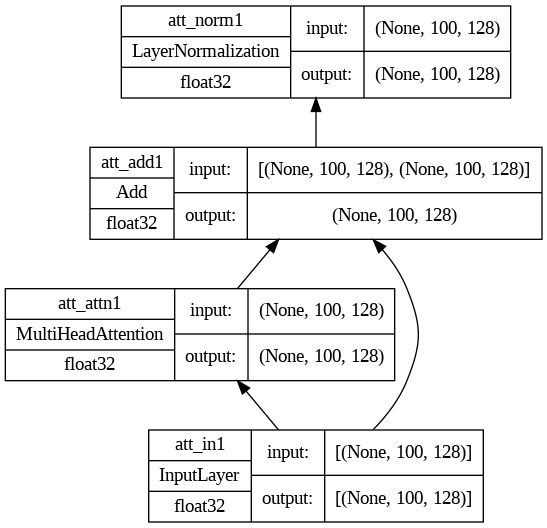

In [ ]:
def self_attention(input_shape, prefix="att", **kwargs):
  inputs = tf.keras.layers.Input(shape=input_shape, dtype='float32',
                                 name=f"{prefix}_in1")

  attention = tf.keras.layers.MultiHeadAttention(name=f"{prefix}_attn1",
                                                 **kwargs)
  drop = tf.keras.layers.Dropout(rate=0.1, name=f"{prefix}_drop_in_the_attention")
  norm = tf.keras.layers.LayerNormalization(name=f"{prefix}_norm1")
  add = tf.keras.layers.Add(name=f"{prefix}_add1")
  # functional API to connect input to output
  attout = attention(key=inputs, value=inputs, query=inputs)



  outputs = norm(add([inputs, attout]))
  # create model and return
  model = tf.keras.Model(inputs=inputs, outputs=outputs, name=f"{prefix}_att")
  return model

seq_length = 100
key_dim = 128
num_heads = 8

model = self_attention(input_shape=(seq_length,key_dim),
                       num_heads=num_heads, key_dim=key_dim)
tf.keras.utils.plot_model(model, "self-attention.png",
                          show_shapes=True, show_dtype=True,
                          show_layer_names=True,
                          rankdir="BT", show_layer_activations=True)

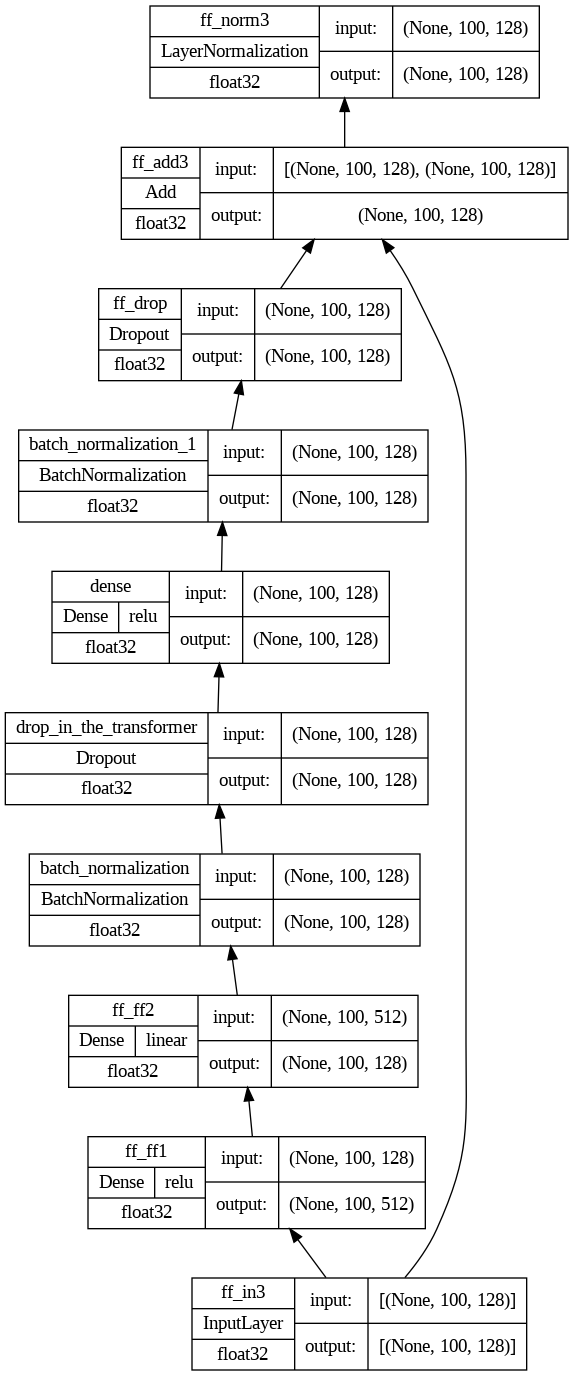

In [ ]:
def feed_forward(input_shape, model_dim, ff_dim, dropout=0.1, prefix="ff"):
  # create layers
  inputs = tf.keras.layers.Input(shape=input_shape, dtype='float32',
                                 name=f"{prefix}_in3")
  dense1 = tf.keras.layers.Dense(ff_dim, name=f"{prefix}_ff1",
                                 activation="relu")
  dense2 = tf.keras.layers.Dense(model_dim, name=f"{prefix}_ff2")

  batch_norm_layer = tf.keras.layers.BatchNormalization(momentum=0.9, epsilon=1e-5)

  drop1 = tf.keras.layers.Dropout(rate=0.1, name="drop_in_the_transformer")
  # Global Average Pooling Layer
  final2 = tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))
  batch_norm_layer2 = tf.keras.layers.BatchNormalization(momentum=0.9, epsilon=1e-5)

  drop2 = tf.keras.layers.Dropout(dropout, name=f"{prefix}_drop")

  add = tf.keras.layers.Add(name=f"{prefix}_add3")

  # functional API to connect input to output
  ffout = drop2(batch_norm_layer2(final2(drop1(batch_norm_layer(dense2(dense1(inputs)))))))

  norm = tf.keras.layers.LayerNormalization(name=f"{prefix}_norm3")

  outputs = norm(add([inputs, ffout]))
  # create model and return
  model = tf.keras.Model(inputs=inputs, outputs=outputs, name=f"{prefix}_ff")
  return model

seq_length = 100
key_dim = 128
embed_dim = 512
ff_dim = 512

model = feed_forward(input_shape=(seq_length, key_dim),
                     model_dim = key_dim,
                     ff_dim = ff_dim)
tf.keras.utils.plot_model(model, "feedforward.png",
                          show_shapes=True, show_dtype=True,
                          show_layer_names=True,
                          rankdir="BT",
                          show_layer_activations=True)

In [ ]:
# Encoder

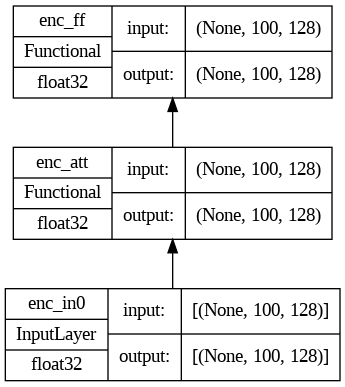

In [ ]:
def encoder(input_shape, key_dim, ff_dim,
            dropout= 0.1, prefix="enc", **kwargs):
  model = tf.keras.models.Sequential([
      tf.keras.layers.Input(shape=input_shape, dtype='float32',
                            name=f"{prefix}_in0"),
      self_attention(input_shape, prefix=prefix, key_dim=key_dim, **kwargs),
      feed_forward(input_shape, key_dim, ff_dim, dropout, prefix),

  ], name=prefix)
  return model

seq_length = 100
key_dim = 128
ff_dim = 512
num_heads = 8

model = encoder(input_shape=(seq_length, key_dim),
                key_dim = key_dim, ff_dim = ff_dim,
                num_heads=num_heads)

tf.keras.utils.plot_model(model, "encoder.png",
                          show_shapes=True,
                          show_dtype=True,
                          show_layer_names=True,
                          rankdir="BT",
                          show_layer_activations=True)

In [ ]:
# Transformer

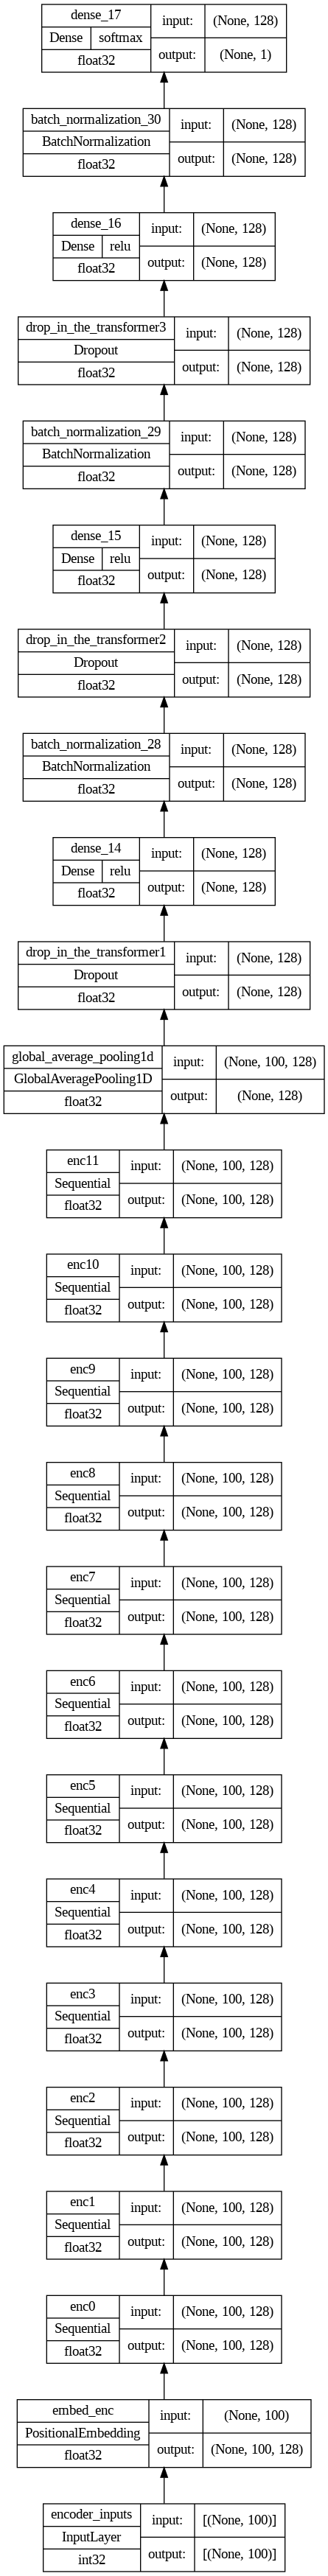

In [ ]:
def transformer(num_layers, num_heads,
                seq_len, key_dim, ff_dim,
                vocab_size_src, vocab_size_tgt,
                dropout=0.1, name="transformer"):

  embed_shape = (seq_len, key_dim) # output shape of positional embedding layer

  input_enc = tf.keras.layers.Input(shape=(seq_len,),
                                    dtype='int32',
                                    name='encoder_inputs')

  embed_enc = PositionalEmbedding(seq_len,
                                  vocab_size_src, embed_dim=key_dim,
                                  name="embed_enc")

  encoders = [encoder(input_shape=embed_shape,
                      key_dim = key_dim,
                      ff_dim = ff_dim,
                      dropout=dropout,
                      prefix=f"enc{i}",
                      num_heads=num_heads)
              for i in range(num_layers)]

  final1 = tf.keras.layers.GlobalAveragePooling1D()

  drop1 = tf.keras.layers.Dropout(rate=0.1, name="drop_in_the_transformer1")
  # Global Average Pooling Layer
  final2 = tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))
  batch_norm_layer1 = tf.keras.layers.BatchNormalization(momentum=0.9, epsilon=1e-5)


  drop2 = tf.keras.layers.Dropout(rate=0.1, name="drop_in_the_transformer2")
  # Global Average Pooling Layer
  final3 = tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))
  batch_norm_layer2 = tf.keras.layers.BatchNormalization(momentum=0.9, epsilon=1e-5)

  drop3 = tf.keras.layers.Dropout(rate=0.1, name="drop_in_the_transformer3")
  # Global Average Pooling Layer
  final4 = tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))
  batch_norm_layer3 = tf.keras.layers.BatchNormalization(momentum=0.9, epsilon=1e-5)





  final5 = tf.keras.layers.Dense(1, activation='softmax')

  # build output
  x1 = embed_enc(input_enc)

  for layer in encoders:
    x1 = layer(x1)

  output = final1(x1)
  output = drop1(output)

  output = final2(output)

  output = batch_norm_layer1(output)

  output = drop2(output)

  output = final3(output)

  output = batch_norm_layer2(output)

  output = drop3(output)

  output = final4(output)

  output = batch_norm_layer3(output)

  output = final5(output)



  try:
    del output._keras_mask
  except AttributeError:
    pass

  model = tf.keras.Model(inputs=[input_enc],
                         outputs=output, name=name)
  return model

seq_len = 100
num_layers = 12
num_heads = 8
key_dim = 128
ff_dim = 512

dropout = 0.1

vocab_size_en = 10000


model = transformer(num_layers, num_heads, seq_len, key_dim,
                    ff_dim, vocab_size_en, dropout)

tf.keras.utils.plot_model(model, "transformer.png",
                          show_shapes=True, show_dtype=True,
                          show_layer_names=True,
                          rankdir="BT",
                          show_layer_activations=True)



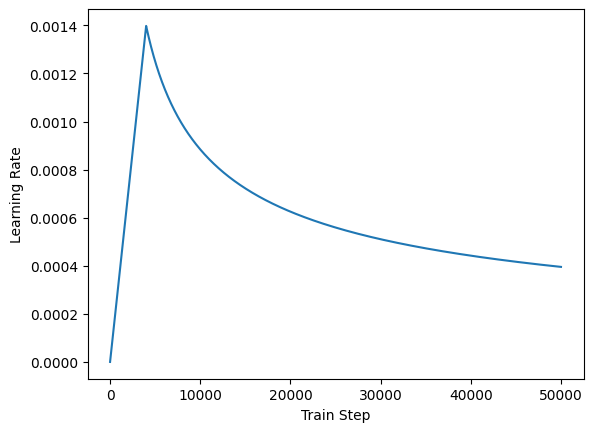

In [ ]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  # custom learning rate for adam optimizer
  def __init__(self, key_dim, warmup_steps=4000):
    super().__init__()
    self.key_dim = key_dim
    self.warmup_steps = warmup_steps
    self.d = tf.cast(self.key_dim, tf.float32)

  def __call__(self, step):
    step = tf.cast(step, dtype=tf.float32)
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)
    return tf.math.rsqrt(self.d) * tf.math.minimum(arg1, arg2)

  def get_config(self):
    config = {
        'key_dim': self.key_dim,
        'warmup_steps': self.warmup_steps,
    }
    return config


key_dim = 128
lr = CustomSchedule(key_dim)
optimizer = tf.keras.optimizers.Adam(lr, beta_1 = 0.9, beta_2 = 0.98, epsilon = 1e-9)

plt.plot(lr(tf.range(50000, dtype=tf.float32)))
plt.ylabel('Learning Rate')
plt.xlabel('Train Step')
plt.show()

In [ ]:
# Compile

In [ ]:

def masked_loss(label, pred):
    mask = label != 0

    loss_object = tf.keras.losses.BinaryCrossentropy(
        from_logits=True, reduction='none')
    loss = loss_object(label, pred)

    mask = tf.cast(mask, dtype=loss.dtype)
    loss *= mask
    loss = tf.reduce_sum(loss)/tf.reduce_sum(mask)
    return loss
'''
def regular_loss(label, pred):
    loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    loss = loss_object(label, pred)
    return loss


def regular_accuracy(label, pred):
    # Apply a threshold (e.g., 0.5) to convert logits to binary predictions (0 or 1)
    binary_pred = tf.math.round(tf.sigmoid(pred))

    # Compare binary predictions to true labels
    match = tf.equal(binary_pred, label)

    # Calculate accuracy
    accuracy = tf.reduce_mean(tf.cast(match, dtype=tf.float32))
    return accuracy

'''
def masked_accuracy(label, pred):
    # pred = tf.argmax(pred, axis=2)
    label = tf.cast(label, pred.dtype)
    match = label == pred

    mask = label != 0

    match = match & mask

    match = tf.cast(match, dtype=tf.float32)
    mask = tf.cast(mask, dtype=tf.float32)
    return tf.reduce_sum(match)/tf.reduce_sum(mask)


In [ ]:
'''
def masked_loss(label, pred):
  mask = tf.cast(tf.math.not_equal(label, 0), tf.float32)

  loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE) # remove, from_logits=True?
  loss = loss_object(label, pred)
  # print(loss.dtype)

  mask = tf.cast(mask, dtype=loss.dtype)
  loss *= mask
  loss = tf.reduce_sum(loss)/tf.reduce_sum(mask)
  return loss


def masked_accuracy(label, pred):
  pred = tf.cast(tf.greater(pred, 0.5), dtype=label.dtype)
  label = tf.cast(label, pred.dtype)
  match = label == pred

  mask = label != 0

  match = match & mask

  match = tf.cast(match, dtype=tf.float32)
  mask = tf.cast(mask, dtype=tf.float32)
  return tf.reduce_sum(match)/tf.reduce_sum(mask)

'''
'''
def masked_loss(label, pred):
    mask = label != 0

    loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')
    loss = loss_object(label, pred)

    mask = tf.cast(mask, dtype=loss.dtype)
    loss *= mask
    loss = tf.reduce_sum(loss)/tf.reduce_sum(mask)
    return loss


def masked_accuracy(label, pred):
    pred = tf.argmax(pred, axis=2)
    label = tf.cast(label, pred.dtype)
    match = label == pred

    mask = label != 0

    match = match & mask

    match = tf.cast(match, dtype=tf.float32)
    mask = tf.cast(mask, dtype=tf.float32)
    return tf.reduce_sum(match)/tf.reduce_sum(mask)
'''

"\ndef masked_loss(label, pred):\n    mask = label != 0\n\n    loss_object = tf.keras.losses.SparseCategoricalCrossentropy(\n        from_logits=True, reduction='none')\n    loss = loss_object(label, pred)\n\n    mask = tf.cast(mask, dtype=loss.dtype)\n    loss *= mask\n    loss = tf.reduce_sum(loss)/tf.reduce_sum(mask)\n    return loss\n\n\ndef masked_accuracy(label, pred):\n    pred = tf.argmax(pred, axis=2)\n    label = tf.cast(label, pred.dtype)\n    match = label == pred\n\n    mask = label != 0\n\n    match = match & mask\n\n    match = tf.cast(match, dtype=tf.float32)\n    mask = tf.cast(mask, dtype=tf.float32)\n    return tf.reduce_sum(match)/tf.reduce_sum(mask)\n"

In [ ]:
vocab_size_en = 10000

seq_len = 100
num_layers = 12
num_heads = 8
key_dim = 128
ff_dim = 512
dropout = 0.1
model = transformer(num_layers, num_heads, seq_len, key_dim, ff_dim,
                    vocab_size_en, dropout)
lr = CustomSchedule(key_dim)
optimizer = tf.keras.optimizers.Adam(lr, beta_1 = 0.9, beta_2 = 0.98,
                                     epsilon=1e-9, clipvalue=3.0, global_clipnorm=10.0)

model.compile(optimizer=optimizer,
              loss=masked_loss,
              metrics=[masked_accuracy])

model.summary()





Model: "transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_inputs (InputLayer  [(None, 100)]             0         
 )                                                               
                                                                 
 embed_enc (PositionalEmbed  (None, 100, 128)          1280000   
 ding)                                                           
                                                                 
 enc0 (Sequential)           (None, 100, 128)          677248    
                                                                 
 enc1 (Sequential)           (None, 100, 128)          677248    
                                                                 
 enc2 (Sequential)           (None, 100, 128)          677248    
                                                                 
 enc3 (Sequential)           (None, 100, 128)          

In [ ]:
# Training

In [ ]:
# Custom for loop for training, rather than using keras model.fit:
'''
import tensorflow as tf

# Define your model, loss function, optimizer, and metrics
model = ...  # Your model
loss_fn = ...  # Your loss function (e.g., tf.keras.losses.BinaryCrossentropy())
optimizer = ...  # Your optimizer (e.g., tf.keras.optimizers.Adam())
metrics = ...  # Your metrics (e.g., [tf.keras.metrics.Accuracy()])

# Define your dataset (e.g., using tf.data.Dataset)

# Define hyperparameters
num_epochs = ...
batch_size = ...

# Create a training loop
for epoch in range(num_epochs):
    # Initialize metrics for the epoch
    for metric in metrics:
        metric.reset_states()

    # Iterate over batches in the dataset
    for batch_data, batch_labels in dataset.batch(batch_size):
        with tf.GradientTape() as tape:
            # Forward pass
            predictions = model(batch_data, training=True)
            loss = loss_fn(batch_labels, predictions)

        # Compute gradients
        gradients = tape.gradient(loss, model.trainable_variables)

        # Update the model's weights
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

        # Update metrics
        for metric in metrics:
            metric.update_state(batch_labels, predictions)

    # Display training progress (optional)
    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Loss: {loss:.4f}", end=", ")
    print("Metrics:", [f"{metric.name}: {metric.result().numpy():.4f}" for metric in metrics])

# Optionally, save the trained model
model.save("trained_model")
'''

'\nimport tensorflow as tf\n\n# Define your model, loss function, optimizer, and metrics\nmodel = ...  # Your model\nloss_fn = ...  # Your loss function (e.g., tf.keras.losses.BinaryCrossentropy())\noptimizer = ...  # Your optimizer (e.g., tf.keras.optimizers.Adam())\nmetrics = ...  # Your metrics (e.g., [tf.keras.metrics.Accuracy()])\n\n# Define your dataset (e.g., using tf.data.Dataset)\n\n# Define hyperparameters\nnum_epochs = ...\nbatch_size = ...\n\n# Create a training loop\nfor epoch in range(num_epochs):\n    # Initialize metrics for the epoch\n    for metric in metrics:\n        metric.reset_states()\n\n    # Iterate over batches in the dataset\n    for batch_data, batch_labels in dataset.batch(batch_size):\n        with tf.GradientTape() as tape:\n            # Forward pass\n            predictions = model(batch_data, training=True)\n            loss = loss_fn(batch_labels, predictions)\n\n        # Compute gradients\n        gradients = tape.gradient(loss, model.trainable_var

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt

# Define your model and other parameters
seq_len = 100
num_layers = 12
num_heads = 8
key_dim = 128
ff_dim = 512
dropout = 0.3
vocab_size_en = 10000

model = transformer(num_layers, num_heads, seq_len, key_dim,
                    ff_dim, vocab_size_en, dropout)

lr = 0.0001

optimizer = tf.keras.optimizers.Adam(
    lr, beta_1=0.9, beta_2=0.98, epsilon=1e-9, clipvalue=3.0, global_clipnorm=10.0
)

# Define your custom loss function and metric (masked_loss and masked_accuracy)
# ...

# Define your training data (train_ds) and validation data (val_ds)
# ...

# Training loop parameters
epochs = 1
print_frequency = 1  # Print loss every 'print_frequency' iterations

# Initialize lists to store training history
train_loss_history = []
train_accuracy_history = []
val_loss_history = []
val_accuracy_history = []

for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")
    for step, (x_batch, y_batch) in enumerate(train_ds):
      print(x_batch['encoder_inputs'].shape)
      x_batch_float = tf.cast(x_batch['encoder_inputs'], tf.float32)
      # nan_check = tf.debugging.check_numerics(x_batch_float, message="NaN or Inf values in x_batch")
      # inf_check = tf.debugging.check_numerics(x_batch_float, message="Infinite values in x_batch", inf_ok=True)

      try:
        tf.debugging.check_numerics(x_batch_float, message='Checking b')
      except Exception as e:
        assert "Checking x_batch_float : Tensor had NaN values" in e.message

      try:
        tf.debugging.check_numerics(x_batch_float, message='Checking c')
      except Exception as e:
        assert "Checking x_batch_float : Tensor had Inf values" in e.message

      if step == 20:
        print(x_batch['encoder_inputs'])
        print("y value:   ", y_batch)
      elif step == 21:
        print(x_batch['encoder_inputs'])
        print("y value:   ", y_batch)


      # if tf.math.is_nan(x_batch['encoder_inputs'].values).any() or tf.math.is_inf(x_batch['encoder_inputs'].values).any():
      #  print("x_batch contains NaN or infinite values.")
      with tf.GradientTape() as tape:
          y_pred = model(x_batch, training=True)
          loss_value = masked_loss(y_batch, y_pred)  # Use your custom loss function here

      grads = tape.gradient(loss_value, model.trainable_variables)
      optimizer.apply_gradients(zip(grads, model.trainable_variables))

      # Compute and store training accuracy
      accuracy = masked_accuracy(y_batch, y_pred)  # Use your custom accuracy metric here
      train_accuracy_history.append(accuracy)

      # Store training loss
      train_loss_history.append(loss_value.numpy())

      # Print loss and one output example
      if step % print_frequency == 0:
          print(f"Step {step}/{len(train_ds)}, Loss: {loss_value.numpy()}")
          example_output = y_pred[0].numpy()  # Get the output of the first example
          print(f"Example Output: {example_output}")

    # Validation step (similar to training step, but without gradient computation)
    for x_val, y_val in val_ds:
        y_val_pred = model(x_val, training=False)
        val_loss = masked_loss(y_val, y_val_pred)  # Use your custom loss function here
        val_accuracy = masked_accuracy(y_val, y_val_pred)  # Use your custom accuracy metric here
        val_loss_history.append(val_loss.numpy())
        val_accuracy_history.append(val_accuracy)

# Optionally, you can save the trained model at the end
# model.save("eng-fra-transformer.h5")

# Plot training history
fig, axs = plt.subplots(2, figsize=(6, 8), sharex=True)
fig.suptitle('Training History')

x = list(range(len(train_loss_history)))

axs[0].plot(x, train_loss_history, alpha=0.5, label="loss")
axs[0].plot(x, val_loss_history, alpha=0.5, label="val_loss")
axs[0].set_ylabel("Loss")
axs[0].legend(loc="upper right")
axs[1].plot(x, train_accuracy_history, alpha=0.5, label="acc")
axs[1].plot(x, val_accuracy_history, alpha=0.5, label="val_acc")
axs[1].set_ylabel("Accuracy")
axs[1].set_xlabel("Iteration")
axs[1].legend(loc="lower right")

plt.show()

Epoch 1/1
(16, 100)


Step 0/1124, Loss: 0.9382617473602295
Example Output: [1.]
(16, 100)
Step 1/1124, Loss: 1.0007617473602295
Example Output: [1.]
(16, 100)
Step 2/1124, Loss: 0.8757616877555847
Example Output: [1.]
(16, 100)
Step 3/1124, Loss: 1.0632617473602295
Example Output: [1.]
(16, 100)
Step 4/1124, Loss: 1.1257617473602295
Example Output: [1.]
(16, 100)
Step 5/1124, Loss: 1.0632617473602295
Example Output: [1.]
(16, 100)
Step 6/1124, Loss: 0.9382618069648743
Example Output: [1.]
(16, 100)
Step 7/1124, Loss: 1.0632617473602295
Example Output: [1.]
(16, 100)
Step 8/1124, Loss: 1.1257617473602295
Example Output: [1.]
(16, 100)
Step 9/1124, Loss: 1.0007617473602295
Example Output: [1.]
(16, 100)
Step 10/1124, Loss: 0.7507617473602295
Example Output: [1.]
(16, 100)
Step 11/1124, Loss: 1.1257617473602295
Example Output: [1.]
(16, 100)
Step 12/1124, Loss: 1.0007617473602295
Example Output: [1.]
(16, 100)
Step 13/1124, Loss: 1.0632617473602295
Example Output: [1.]
(16, 100)
Step 14/1124, Loss: 1.06326174

KeyboardInterrupt: ignored

In [ ]:
print(x)

In [ ]:
print(val_loss_history)

In [ ]:
print(train_loss_history)

In [ ]:
print(train_accuracy_history)

In [ ]:
print(val_accuracy_history)

In [ ]:
seq_len = 100
num_layers = 12

num_heads = 8
key_dim = 128
ff_dim = 512
dropout = 0.1
vocab_size_en = 10000


model = transformer(num_layers, num_heads, seq_len, key_dim,
                    ff_dim, vocab_size_en, dropout)

lr = 0.0001

optimizer = tf.keras.optimizers.Adam(lr, beta_1 = 0.9, beta_2 = 0.98,
                                     epsilon = 1e-9, clipvalue=0.5, clipnorm=1.0)

model.compile(optimizer=optimizer,
              loss=masked_loss,
              metrics=[masked_accuracy])

epochs = 5

history = model.fit(train_ds, epochs=epochs, validation_data=val_ds)

# model.save("eng-fra-transformer.h5")

fig, axs = plt.subplots(2, figsize=(6, 8), sharex=True)

fig.suptitle('Training History')

x = list(range(1, epochs + 1))

axs[0].plot(x, history.history["loss"], alpha=0.5, label="loss")
axs[0].plot(x, history.history["val_loss"], alpha=0.5, label="val_loss")
axs[0].set_ylabel("Loss")
axs[0].legend(loc="upper right")
axs[1].plot(x, history.history["masked_accuracy"], alpha=0.5, label="acc")
axs[1].plot(x, history.history["val_masked_accuracy"], alpha=0.5, label="val_acc")
axs[1].set_ylabel("Accuracy")
axs[1].set_xlabel("epoch")
axs[1].legend(loc="lower right")

plt.show()

In [ ]:
print(history.history["loss"])

In [ ]:
custom_objects = {'PositionalEmbedding': PositionalEmbedding,
                  'CustomSchedule': CustomSchedule,
                  'masked_loss': masked_loss,
                  'masked_accuracy': masked_accuracy}

with tf.keras.utils.custom_object_scope(custom_objects):
  model = tf.keras.models.load_model('eng-fra-transformer.h5')

seq_len = 100
vocab_size_en = 10000
vocab_size_fr = 20000

def translate(sentence):
  enc_tokens = eng_vectorizer([sentence])
  lookup = list(fra_vectorizer.get_vocabulary())
  start_sentinel, end_sentinel = "[start]", "[end]"
  output_sentence = [start_sentinel]
  # generate the translated sentence word by word
  for i in range(seq_len):
    vector = fra_vectorizer([' '.join(output_sentence)])
    assert vector.shape == (1, seq_len + 1)
    dec_tokens = vector[:, :-1]
    assert dec_tokens.shape == (1, seq_len)
    pred = model([enc_tokens, dec_tokens])
    assert pred.shape == (1, seq_len, vocab_size_fr)
    word = lookup[np.argmax(pred[0, i, :])]
    output_sentence.append(word)
    if word == end_sentinel:
      break
  return output_sentence

test_count = 20
for n in range(test_count):
  english_sentence, french_sentence = random.choice(test_pairs)
  translated = translate(english_sentence)
  print(f"Test {n}:")
  print(f"{english_sentence}")
  print(f"== {french_sentence}")
  print(f"-> {' '.join(translated)}")
  print()